In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
import pandas as pd
import time
import math
import gc
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor
import nltk 
from sklearn.model_selection import train_test_split
import xgboost as xgb
import random
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,5)
import numpy as np 
import pandas as pd 
from xgboost import plot_importance
import xgboost as xg 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error as MSE 

In [ ]:
df_train=pd.read_csv("drive/MyDrive/Datasets-Collab/Workstation/Train.csv")
df_test=pd.read_csv("drive/MyDrive/Datasets-Collab/Workstation/Test.csv")
submission=pd.read_csv("drive/MyDrive/Datasets-Collab/Workstation/sample submission.csv")


In [ ]:
#concat train and test

In [ ]:
#df_train.drop(df_train.loc[df_train['Uniq Id']=='69fe31907446f8f8e098122ebb3dcf68'].index,axis=0,inplace=True)

In [ ]:
temp=df_train[['Package Name', 'Package Type', 'Destination', 'Itinerary',
       'Places Covered', 'Travel Date', 'Hotel Details', 'Start City',
       'Airline', 'Flight Stops', 'Meals', 'Sightseeing Places Covered',
       'Cancellation Rules']]

temp[temp.duplicated()].index

Int64Index([ 3854,  3858,  6832,  6915,  8334, 11991, 13868, 14480, 14745,
            16827, 17078, 17551, 18392, 18760, 19085, 19144, 19188, 20609,
            20860, 20954],
           dtype='int64')

In [ ]:
index_drop=[ 3854,  3858,  6832,  6915,  8334, 11991, 13868, 14480, 14745,
            16827, 17078, 17551, 18392, 18760, 19085, 19144, 19188, 20609,
            20860, 20954]

df_train.drop(index_drop,inplace=True)

In [ ]:
merged=pd.concat([df_train,df_test])
merged=merged.reset_index()
merged.drop(['index'],axis=1,inplace=True)

In [ ]:
merged=merged.replace({'Alibagh':'Alibag'},regex=True)
merged=merged.replace({'Chikmangalur':'Chikmagalur'},regex=True)
merged=merged.replace({'Tiruchirapally': 'Tiruchirappalli'},regex=True)


In [ ]:
#calculating distance

In [ ]:
temp=pd.DataFrame(columns=['Destination','Start_city'])
temp['Start_city']=merged['Start City'].copy()
temp['Destination']=merged['Destination'].str.split('|',expand=True)[0].copy()
temp['Distance']=0

Delhi_cord=(28.6138954, 77.2090057)
Mumbai_cord=(19.0759899, 72.8773928)


from geopy.geocoders import Nominatim
import geopy.distance

geolocator = Nominatim(user_agent = "geoapiExercises")

coordinates_cities={}
for values in temp['Destination'].unique():
  location = geolocator.geocode(values,timeout=10000)
  cords=(location.latitude, location.longitude)
  coordinates_cities[values]=cords

delhi_distance={}
mumbai_distance={}

for key,values in coordinates_cities.items():
  d_distance=geopy.distance.vincenty(Delhi_cord, values).km
  m_distance=geopy.distance.vincenty(Mumbai_cord, values).km
  delhi_distance[key]=d_distance
  mumbai_distance[key]=m_distance


for index,row in temp.iterrows():
  if(row['Start_city']=='New Delhi'):
    destination_city=row['Destination']
    total_distance=delhi_distance[destination_city]
    temp.at[index,'Distance']=total_distance

  else:
    destination_city=row['Destination']
    total_distance=mumbai_distance[destination_city]
    temp.at[index,'Distance']=total_distance

merged['Distance_km']=temp['Distance'].copy()

In [ ]:
# flights included

In [ ]:
merged['Package Name']=merged['Package Name'].str.lower()
merged.loc[merged['Package Name'].str.contains('with flights'),'flights_included']=1
merged['flights_included'].fillna(0,inplace=True)

In [ ]:
# #Package Name tfidf
# from sklearn.feature_extraction.text import TfidfVectorizer
# merged['Package Name']=merged['Package Name'].str.replace('\W+',' ')
# merged['Package Name']=merged['Package Name'].str.lower()
# feature_count = 25
# tfidf = TfidfVectorizer(max_features=feature_count)
# Package_features = pd.DataFrame(tfidf.fit_transform(merged['Package Name']).toarray())

# Package_features.columns=[*range(0,25)]
# Package_features.columns = [str(col) + 'Package_Name_' for col in Package_features.columns]

# merged=pd.concat([Package_features,merged],axis=1)

In [ ]:
# Cancellation Policy

In [ ]:
# cancel_encode=LabelEncoder()
# merged['Cancellation Rules']=cancel_encode.fit_transform(merged['Cancellation Rules'])
# merged.loc[merged['Cancellation Rules']==2,'Cancellation Rules']=1
# merged.loc[merged['Cancellation Rules']==9,'Cancellation Rules']=6
# merged.loc[merged['Cancellation Rules']==7,'Cancellation Rules']=6

In [ ]:
# tfidf hotel name

In [ ]:
temp=pd.DataFrame()
temp['Hotel Details']=merged['Hotel Details'].copy()

temp.loc[temp['Hotel Details']=='Not Available','Hotel Details']=None
temp['Hotel Details'].fillna(0,inplace=True)
temp['Hotel Details']=temp['Hotel Details'].str.replace('1','')
temp['Hotel Details']=temp['Hotel Details'].str.replace('2','')
temp['Hotel Details']=temp['Hotel Details'].str.replace('3','')
temp['Hotel Details']=temp['Hotel Details'].str.replace('4','')
temp['Hotel Details']=temp['Hotel Details'].str.replace('5','')
temp['Hotel Details']=temp['Hotel Details'].str.replace('6','')
temp['Hotel Details']=temp['Hotel Details'].str.replace('7','')
temp['Hotel Details']=temp['Hotel Details'].str.replace('8','')
temp['Hotel Details']=temp['Hotel Details'].str.replace('9','')
temp['Hotel Details']=temp['Hotel Details'].str.replace('0','')
temp['Hotel Details']=temp['Hotel Details'].str.replace('\W+',' ')
temp['Hotel Details']=temp['Hotel Details'].str.lower()
temp["Hotel Details"]=temp["Hotel Details"].str.replace('the','')
temp["Hotel Details"]=temp["Hotel Details"].str.replace('one','')
temp["Hotel Details"]=temp["Hotel Details"].str.replace('two','')
temp["Hotel Details"]=temp["Hotel Details"].str.replace('three','')
temp["Hotel Details"]=temp["Hotel Details"].str.replace('four','')
temp["Hotel Details"]=temp["Hotel Details"].str.replace('five','')
temp["Hotel Details"]=temp["Hotel Details"].str.replace('hotel','')


In [ ]:
temp['Hotel Details'].fillna('-999',inplace=True)

In [ ]:
#mmt special hotels
teemp=pd.DataFrame()
teemp['Hotel Details']=temp['Hotel Details'].copy()
teemp['MMT-Special']=0
merged['MMT-Special']=teemp['Hotel Details'].map(lambda x: x.count('mmt'))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

feature_count = 26

tfidf = TfidfVectorizer(max_features=feature_count)

Package_features = pd.DataFrame(tfidf.fit_transform(temp['Hotel Details']).toarray())

Package_features.columns=[*range(0,26)]
Package_features.columns = [str(col) + 'HotelName_' for col in Package_features.columns]

merged=pd.concat([Package_features,merged],axis=1)

In [ ]:
merged.loc[merged['Hotel Details']=='Not Available','Hotel Details']=None
merged['Hotel Details'].fillna(0,inplace=True)

In [ ]:
merged['Hotel Details'] = merged['Hotel Details'].str.replace('Two','2')
merged['Hotel Details'] = merged['Hotel Details'].str.replace('Three','3')
merged['Hotel Details'] = merged['Hotel Details'].str.replace('Four','4')
merged['Hotel Details'] = merged['Hotel Details'].str.replace('Five','5')

merged['Hotel Details'] = merged['Hotel Details'].str.replace('The Lodhi:A member of The Leading Hotels Of The World','The Lodhi A member of The Leading Hotels Of The World')

temp=pd.DataFrame()
temp['Hotel Details']=merged['Hotel Details']
merged['Hotel Details']=merged['Hotel Details'].str.split('|')
merged['Hotel Details'].fillna(0,inplace=True)

In [ ]:
empty_rating_hotels=[]
for i in merged['Hotel Details']:
  if (i!=0):
    for values in i:
      x=values.split(':')[1]
      if(x==''):
        empty_rating_hotels.append(values)

In [ ]:
#@title
average_rating={'175 Metropolitan Executive Motel on Riccarton:': 4.5,
 'A One Star Hotel Pattaya - MMT Special:': 3.4,
 'ATDC Houseboat:': 3.8,
 'AVANI Atrium Bangkok:': 4.0,
 'Adya Hotel Langkawi - MMT Special:': 4.0,
 'Amari Watergate Hotel Bangkok - MMT Special:': 4.4,
 'Ambassador Hotel Bangkok  MMT Special:': 4.0,
 'Anand Portico:': 4.2,
 'Ananda Lakshmi Ayurveda Retreat:': 4.5,
 'Aonang Paradise Resort Krabi - MMT Special:': 3.4,
 'Apple Valley Resort:': 4.3,
 'Arcadia Heritage Resort:': 3.3,
 'Arcadia Regency:': 3.6,
 'Arrowtown House Boutique Accommodation:': 4.4,
 'Atapattu Walauwa:': 4.0,
 'BEST WESTERN Elyon - MMT HOLIDAYS SPECIAL:': 4.0,
 'Beach & Lake Ayurvedic Resort:': 4.1,
 'Best Western Kuta Beach-MMT Special:': 3.1,
 'Bhanwar Singh Palace:': 3.7,
 'Blue Bells Valley Resort:': 4.4,
 'Brys Caves:': 4.3,
 'COCOLAND HERITAGE BEACH RESORT:': 3.5,
 'California Group of Houseboats:': 3.5,
 'Camelot Beach Hotel:': 4.0,
 'Camelot Hotel, Alleppey- MMT Holidays Special:': 3.9,
 'Casino Hotel - Cgh Earth-MMT Holidays Special:': 4.5,
 'Casino Hotel - Cgh Earth:': 4.4,
 'Centara Ceysands Resort (MMT HOLIDAYS SPECIAL):': 3.5,
 'Cinnamon Bey Beruwala Hotel(MMT HOLIDAYS SPECIAL):': 4.0,
 'Cinnamon Thekkady:': 4.4,
 'Clarkes Hotel, A grand heritage hotel since 1898:': 4.9,
 'Clarks Resort Abhyaran, Ranthambore:': 4.6,
 'Club Mahindra Poovar:': 4.1,
 'Coco Royal Beach-MMT HOLIDAYS SPECIAL:': 4.0,
 'Cocobay Resort:': 3.7,
 "Copthorne King's Hotel - MMT Special:": 3.5,
 'Coral Cove-MMT HOLIDAYS SPECIAL:': 4.8,
 'Corbett Adventure Resort:': 3.8,
 'Country Resort By AHRPL, Katra:': 4.5,
 'Crown Valley-MMT Holidays Special:': 4.1,
 'Deevana Patong Resort & Spa - MMT Special:': 4.1,
 'Delight Lachen Heritage:': 3.2,
 'Desert Springs Resort:': 4.5,
 'Detour Moonlight:': 5.0,
 'Diviyum Manor-MMT Holidays Special:': 3.1,
 'DoubleTree by Hilton Resort  & Spa Marjan Island:': 4.8,
 'Dubai Marriott Hotel Al Jaddaf-MMT Special:': 5.0,
 'Dusit Thani Krabi Beach Resort - MMT SPECIAL:': 4.2,
 'Economy Houseboat by ATDC  - MMT Special:': 4.5,
 'Elephant Route Resort-MMT Holidays Special:': 3.9,
 'Elephant Route Resort:': 3.9,
 'Elixir Hills Suites Resort & Spa-MMT Holidays Special:': 4.5,
 'Estuary Sarovar Portico:': 4.4,
 'Evoke Avaas Lifestyle:': 3.7,
 'Fair View Hotel Colombo:': 4.0,
 'Fateh Garh Resort by Fateh Collection:': 4.8,
 'Federal Hotel - MMT Special:': 3.7,
 'Fernhill Resort:': 3.5,
 "Fortune Resort Bay Island-Member ITC's Hotel Group:": 4.2,
 'Fortune Resort Sullivan Court-Member ITC Hotel Group:': 4.2,
 'Furama Bukt Bintang - MMT Special:': 4.0,
 'Furama Hotel Bukit Bintang:': 4.0,
 'Galadari Hotel-MMT HOLIDAYS SPECIAL:': 3.5,
 'Gateway Varkala - IHCL SeleQtions:': 3.9,
 'Gem Park:': 4.1,
 'Genting Dream Ex Sin - MMT Special:': 4.0,
 'Grand Ion Delemen- MMT Special:': 4.0,
 'Grand Nirvana Jacuzzi Super Luxury Houseboat:': 4.4,
 'Grand View Hotel:': 4.5,
 'Greenwoods Resort:': 4.7,
 'HAVELOCK HOLIDAY BEACH RESORT:': 3.3,
 'HAYWIZZ HAVELOCK ISLAND RESORTS:': 3.7,
 'HOTEL GATEWAY SHILLONG:': 3.5,
 'HOTEL HERITAGE MANDAWA:': 3.9,
 'HOTEL NANDA:': 4.9,
 'HOTEL PINK MOUNTAIN-MMT HOLIDAYS SPECIAL:': 3.9,
 'Hard Rock Hotel Penang:': 3.9,
 'Haus Berlin:': 4.2,
 'Havelock Country Homes- MMT Holiday Special:': 3.3,
 'Havelock Country Homes:': 4.1,
 'Heaven Seven-MMT HOLIDAYS SPECIAL:': 3.9,
 'Heritage Kuchaman Haveli:': 3.8,
 'Heritage Madurai:': 4.4,
 'Hilton Garden Inn Dubai Al Muraqabat (Deira) - MMT Special:': 4.0,
 'Hilton Garden Inn New Delhi Saket:': 4.4,
 'Hilton Garden Inn:': 4.6,
 'Hilton Pattaya - MMT Special:': 4.2,
 'Holiday Inn Express Krabi Ao Nang  MMT Special:': 3.3,
 'Holiday Inn Resort Batam:': 3.1,
 'Holiday Villa Beach Resort & Spa Langkawi MMT Special:': 3.5,
 'Hotel 100 Petals- MMT HOLIDAYS SPECIAL:': 4.1,
 'Hotel 100 Petals:': 4.5,
 'Hotel 6 Chandigarh Zirakpur(Medallion):': 4.0,
 'Hotel Baljees Regency:': 3.8,
 'Hotel Boss - MMT Special:': 3.7,
 'Hotel Continental Blue:': 4.0,
 'Hotel Ganga Vilas:': 3.5,
 'Hotel Hilltone:': 4.1,
 'Hotel Hillview, Munnar - MMT Special:': 4.0,
 'Hotel Horizon:': 3.8,
 'Hotel Jem Valley:': 3.8,
 'Hotel Master Paradise:': 3.9,
 'Hotel Maya Kuala Lumpur - MMT Special:': 4.1,
 'Hotel Pegasus Crown:': 2.9,
 'Hotel Port Palace:': 4.0,
 'Hotel Radhika Palace:': 3.9,
 'Hotel Rains Inn:': 3.9,
 'Hotel Ranthambhore National Resort:': 3.8,
 'Hotel Royale Park:': 3.9,
 'Hotel Sandra Palace-MMT Holidays Special:': 4.0,
 'Hotel Shompen:': 3.4,
 'Hotel Silver Oak (A Boutique Garden Hotel):': 4.3,
 'Hotel Sivamurugan:': 4.0,
 'Hotel Span International-MMT Holidays Special:': 4.0,
 'Hotel Temple Citi:': 4.2,
 'Hotel The Royal Plaza:': 3.7,
 'Hotel Treetop:': 4.1,
 'Hotel Udai Vilas Palace:': 3.5,
 'Hotel Vintage:': 3.7,
 'Hotel Welbeck Residency:': 3.2,
 'Hotel Yois Udaipur - MMT Holidays Special:': 4.1,
 'Hummingbird Resort:': 3.3,
 'Hyatt Place Rameswaram:': 4.4,
 'Hyatt Regency Amritsar:': 4.3,
 'Hyatt Regency- MMT Holidays Special:': 4.4,
 'INFINITEA TEA GARDEN RESORT:': 4.5,
 'Ibis Styles Fraser Business Park - MMT Special:': 3.4,
 'Iceberg Hill Hotel-MMT Holidays Special:': 3.9,
 'Indana Palace Jodhpur:': 4.3,
 'Indra Maya Pool Villas:': 4.0,
 'J Hotel:': 3.3,
 'JW Marriott Chandigarh:': 4.7,
 'JW Marriott Mussoorie Walnut Grove:': 4.6,
 'Jain Group Lachung Continental:': 3.4,
 'Jain Group Sanderling Resort & spa:': 4.1,
 'Jet Park Hotel Auckland Airport:': 4.5,
 'Jungle Vilas:': 3.7,
 'KAZIRANGA FLORICAN LODGE:': 3.8,
 'KOFILAND:': 4.4,
 'Keys Select Hotel Aqua Green-MMT Holidays Special:': 4.8,
 'Keys Select Hotel Kochi-MMT Holidays Special:': 3.9,
 'King Thai Hotel and Restaurant Cum Bar:': 4.7,
 'Kshetra Ayurveda & Yoga Retreat, Varkala:': 4.3,
 'Kuta Central Park Hotel - MMT Special:': 4.0,
 'Kyriad Hotel Shimla (A unit of Hotel C K Int.):': 3.6,
 'Lake Palace Backwater Resort:': 4.4,
 'Larisa Resort:': 4.7,
 'Le Fenix - MMT Special:': 3.3,
 'Leisure Inn Grand Chanakya:': 3.9,
 'Leisure inn grand chanakya - MMT Holidays Special:': 4.1,
 'Lemon Tree Hotel  Gangtok:': 4.2,
 'Lemon Tree Premier Jaipur:': 4.3,
 'Little Mastiff Dharamshala - Unit Of Pong View Hotel:': 3.9,
 'Long Beach Resort & Spa - MMT Special:': 4.0,
 'MERCURE SINGAPORE ON STEVENS - MMT SPECIAL:': 4.0,
 'Madurai Residency:': 4.1,
 "Magellan's Group The Grand Lachen:": 3.0,
 'Maharaja Ganga Mahal:': 4.2,
 'Mandarin Oriental, Singapore:': 4.5,
 'Marari Beach - CGH Earth:': 4.5,
 'Mayfair Himalayan Spa Resort:': 4.6,
 'Mayfair Hotel:': 4.6,
 'Mayfair Spa Resort & Casino:': 4.6,
 'Megapode Resort:': 4.0,
 'Metro Hotel Bukit Bintang - MMT Special:': 3.5,
 'Moksha Himalaya Spa Resort:': 4.4,
 'Mount Himalayan Hotel & Spa-MMT Holidays Special:': 4.0,
 'Mount Lavinia Hotel (MMT HOLIDAYS SPECIAL):': 4.0,
 'Mount Lavinia Hotel-MMT HOLIDAYS SPECIAL:': 4.0,
 'Mountain Club Resort-MMT Holidays Special:': 4.3,
 'Movenpick Hotel Bur Dubai-MMT Special:': 4.7,
 'Movenpick Hotel Colombo:': 4.5,
 'Movenpick Hotel Myth Patong - MMT Special:': 4.3,
 'Movenpick Hotel Sukhumvit 15 - MMT Special:': 4.5,
 'Movenpick Resort and Spa Karon Beach Phuket - MMT Special:': 4.2,
 'Niraamaya Retreats Backwaters and beyond, Kumarakom:': 4.9,
 'Niraamaya Retreats Surya Samudra:': 4.6,
 'Nisala Arana Boutique Hotel:': 4.4,
 'Novotel Bangkok Silom Road - MMT Special:': 4.3,
 'Nubra Ecolodge:': 4.2,
 'OYO 14240 MOHAN RESIDENCY:': 3.4,
 'OYO 22517 Mananya Cottage:': 4.0,
 'OYO 28229 Samfelma Lodge:': 4.3,
 'OYO 45438 RUPSAJJA PARIBAR:': 5.0,
 'OYO 47847 Himalayan Brook:': 4.5,
 'OYO 48394 Hotel Ratna Saver:': 4.5,
 'OYO Home 42381 Budget Stay Near Medical College:': 5.0,
 'Oak Ray City Hotel-MMT HOLIDAYS SPECIAL:': 4.0,
 'Oakwood Hotel Journeyhub Phuket - MMT Special:': 3.1,
 'Ocean Bay Ayurvedic Beach Resort:': 3.2,
 'Omega Residency:': 3.9,
 'One Farrer Hotel:': 4.6,
 'Orchard Hotel Singapore:': 4.0,
 'Over The Hill:': 4.4,
 'Oxygen Resorts Alleppey-MMT Holidays Special:': 4.0,
 'PARKROYAL Parramatta:': 4.0,
 'PARKROYAL on Kitchener Road:': 4.0,
 'Pacific Regency Hotel Suite - MMT Special:': 3.7,
 'Palace Hotel (Bikaner House), A Heritage Hotel:': 4.3,
 'Palette - Pine Tree Spa Resort:': 3.6,
 'Palmtree Leaf-MMT Holidays Special:': 3.9,
 'Pappukutty Beach Resort:': 3.4,
 'Parakkat Nature Resorts-MMT Holidays Special:': 4.6,
 'Parakkat Nature Resorts:': 4.5,
 'Park Hotel Farrer Park - MMT Special:': 4.1,
 'Park Plaza - MMT Holidays Special:': 4.3,
 'Park Regis Aveda Kumarakom:': 4.5,
 'Park Regis Jaipur - MMT Holidays Special:': 4.3,
 'Pavilions Hotel:': 4.0,
 'Pearl Grand Hotel-MMT HOLIDAYS SPECIAL:': 4.0,
 'Pearl Park Beach Resort-MMT Holidays Special:': 3.3,
 'Pearl Park Beach Resort:': 3.7,
 'Poovar Island Resort:': 4.2,
 'Poppys Hotel:': 4.1,
 'Punnamada Resort:': 4.0,
 'Pushkar Resorts:': 4.3,
 'Quality Airport Hotel:': 4.1,
 'Quality Hotel Marlow:': 3.0,
 "Queen's Hotel, Kandy(MMT HOLIDAYS SPECIAL):": 4.1,
 'R.J Resorts Ltd.:': 3.9,
 'RAMADA JAIPUR:': 4.2,
 'ROOPKATHA  HOTEL KALIMPONG:': 3.9,
 'Radisson Blu Haridwar:': 4.2,
 'Radisson Blu Hotel Dubai Deira Creek - MMT Special:': 4.5,
 'Radisson Blu Hotel, Abu Dhabi Yas Island:': 4.4,
 'Radisson Hotel Varanasi:': 3.9,
 'Radisson Srinagar:': 4.0,
 'Raffles Jakarta:': 5.0,
 'Raj Palace Resort, Ranthambhore:': 3.3,
 'Ramada Alleppey:': 4.0,
 'Ramada Plaza Chandigarh:': 4.3,
 'Ramada by Wyndham Darjeeling Gandhi Road:': 4.3,
 'Ramada by Wyndham Phuket Deevana Patong - MMT Special:': 4.3,
 'Red Fox Hotel - MMT Holiday Special:': 3.8,
 'Red Fox Hotel Chandigarh:': 3.7,
 'Red Fox Hotel Delhi Airport:': 3.6,
 'Regenta Central Antarim:': 4.3,
 'Renai Green Fields:': 3.8,
 'Resorts World Genting,Resort Hotel:': 3.5,
 'Royal Group of Deluxe Houseboats:': 3.7,
 'Royal Sarovar Portico:': 4.0,
 'S R CASTLE:': 3.7,
 'SDM Golden Tower:': 4.0,
 'SUMITEL SUITES & SPA:': 4.1,
 'Sagara Beach Resort - MMT Holidays Special:': 3.9,
 'Sagara Beach Resort:': 3.8,
 'Saira fort by Sarovar - MMT Holidays Special:': 4.2,
 'San Nael LaResort:': 4.1,
 'Savoy Ooty - IHCL SeleQtions:': 4.5,
 'Sea Shell Neil Island:': 4.6,
 'Sea Shell Resort-MMT Holidays Special:': 4.9,
 'Sea Shell Samssara:': 4.3,
 'Shree Ram International:': 3.8,
 'Shri Ram Empire:': 4.1,
 'Siam Bayshore Resort Pattaya:': 4.5,
 'Silver Sand Beach Resort:': 4.0,
 'SkyCity Grand Hotel:': 4.5,
 'Snow Valley Resorts:': 4.3,
 'Solang Valley Resort:': 4.0,
 'Soma Kerala Palace:': 3.9,
 'Sugar Beach Mauritius - MMT Special:': 4.9,
 'Sumi Yashshree Suites & Spa:': 4.2,
 'Summit Alpine Resort, Lachung- MMT Holidays Special:': 4.0,
 'Summit Alpine Resort:': 3.8,
 'Summit Barsana Resort & Spa-MMT HOLIDAY SPECIAL:': 3.4,
 'Summit Denzong Hotel & Spa:': 4.1,
 'Summit Grace Hotel:': 3.6,
 'Summit Hampton Hotel, Thekkady - MMT Holidays Special:': 3.8,
 'Summit Hotel KL City Centre - MMT Special:': 3.9,
 'Summit Namnang Courtyard & Spa, Gangtok-MMT Holidays Special:': 3.6,
 'Summit Namnang Courtyard & Spa:': 4.0,
 'Summit Newa Regency:': 3.8,
 'Summit Swiss Heritage Hotel & Spa:': 3.9,
 'Sunrise Beach Resort:': 3.0,
 'Sunshine Hip Pattaya - MMT Special:': 3.4,
 'Swades My Home:': 4.8,
 'THARANGINI HOUSEBOATS:': 4.1,
 'THE SHERGARH RANTHAMBHORE:': 4.2,
 'TSG Aura-MMT Holidays Special:': 3.4,
 'TSG Emerald-MMT Holidays Special:': 4.1,
 'TSG Grand-MMT Holidays Special:': 4.1,
 'Taj Exotica Resort & Spa, Andamans:': 4.7,
 'Taj Exotica Resort & Spa-MMT Holidays Special:': 4.0,
 'Taj Kumarakom Resort and Spa - MMT Holidays Special:': 4.4,
 'Taj Umaid Bhawan Palace:': 4.7,
 'Tajview IHCL SeleQtions,Agra-MMT Holiday Special:': 4.5,
 'Tango Beach Resort:': 3.4,
 'Tea Village Munnar:': 4.0,
 'Tea Village-MMT Holidays Special:': 3.8,
 'The Ananta:': 4.4,
 'The Anvaya Beach Resort Bali - MMT Special:': 4.8,
 'The Aryan Regency:': 3.8,
 'The Atrium on the Greens:': 4.1,
 'The Chinar Resort & Spa:': 4.5,
 'The Chumbi Mountain Retreat & Spa:': 4.1,
 'The Driftwood Ladakh:': 3.1,
 'The Elgin Mount Pandim Hotel:': 4.2,
 'The Elgin Nor-Khill Hotel:': 4.5,
 'The Elgin Silver Oaks Hotel:': 4.3,
 'The Elgin:': 4.0,
 'The Gateway Hotel Pasumalai Madurai:': 4.5,
 'The Gopinivas Grand:': 3.4,
 'The Khyber Himalayan Resort & Spa:': 4.7,
 'The Laxmi Niwas Palace (A Luxury Heritage Hotel) by MRS Group:': 4.2,
 'The Mountain Courtyard Thekkady:': 4.4,
 'The Mountain Courtyard-MMT Holidays Special:': 4.5,
 'The Oberoi Cecil:': 4.8,
 'The Oberoi Vanyavilas Wildlife Resort, Ranthambhore:': 4.8,
 'The Orchard Retreat & Spa:': 4.7,
 'The Palms-MMT HOLIDAYS SPECIAL:': 4.1,
 'The Pride Inn:': 4.0,
 'The Rosewood Hotel:': 3.6,
 'The Surf Bentota-MMT HOLIDAYS SPECIAL:': 4.0,
 'The Sylverton- Mussoorie, By Leisure Hotels:': 4.0,
 'The Tamara Kodai:': 4.7,
 'The Terrace:': 4.0,
 'The Travancore Heritage Beach Resort:': 4.3,
 'The White Hotels:': 3.9,
 'The Zuri Kumarakom, Kerala Resort & Spa:': 4.5,
 'The rain tree-MMT HOLIDAYS SPECIAL:': 4.0,
 "Tom's Inn Premium:": 3.5,
 'Tree Of Life Nature-MMT HOLIDAYS SPECIAL:': 4.0,
 'Turtle On The Beach:': 4.2,
 'UDAY SAMUDRA LEISURE BEACH HOTEL & SPA-MMT Holidays Special:': 4.1,
 'UDAY SAMUDRA LEISURE BEACH HOTEL & SPA:': 4.2,
 'Udaan Hotel Zambala Retreat:': 4.1,
 'Uday Backwater Resort-MMT Holidays Special:': 4.0,
 'Uday Suites - The Airport Hotel:': 4.4,
 'Vikram Vintage Inn:': 4.1,
 'Vivanta Dal View:': 4.7,
 'Warmth Lake Haven-MMT Holidays Special:': 4.0,
 'Warmth Lake Haven:': 4.1,
 'WelcomHotel Pine N Peak Pahalgam - Member ITC Hotel Group:': 4.3,
 'Welcomheritage Ferrnhills Royale Palace:': 3.6,
 'White Rose Kuta Resort, Villas & Spa:': 4.0,
 'Woraburi Pattaya Resort and Spa - MMT Special:': 4.2,
 'Yatri Niwas:': 3.7,
 'Zen Kerala Holidays:': 5.0,
 'Zone By The Park Jodhpur - MMT Holiday Special:': 4.3,
 'Zone by The Park Jaipur Bani Park - MMT Holiday Special:': 3.9,
 'Zylan Luxury Villa:': 4.5,
 'juSTa Greater Kailash:': 3.9,
 'juSTa Lake Nahargarh Palace:': 4.0,
 'juSTa Rajputana:': 4.2,
 'sandyy wavess Beach Resort:': 4.7}

In [ ]:
# average_rating={}
# no_rating_hotels=[]
# for empty_hotels in sorted(empty_rating_hotels):
#   rating=[]
#   for hotels in merged['Hotel Details']:
#     if(hotels!=0):
#       for values in hotels:
#         if(empty_hotels in values):
#           x=values.split(':')[1]
#           if(x!=''):
#             rating.append(float(x))

#   if(len(rating)!=0):
#     average_rating[empty_hotels]=round(sum(rating)/len(rating),1)
#   else:
#     no_rating_hotels.append(empty_hotels)

# no_rating_hotels=sorted(set(no_rating_hotels))

In [ ]:
temp1=temp['Hotel Details'].str.split('|',expand=True).copy()
temp1.columns=[*range(0,11)]

In [ ]:
for hotels, ratings in average_rating.items():
  temp1=temp1.replace([hotels],hotels+str(ratings))

In [ ]:
for i in temp1.columns:
  temp1[i]=temp1[i].str.split(':',expand=True)[1]
temp1=temp1.replace('',None)
temp1 = temp1.apply(pd.to_numeric)

temp1['average_hotel_rating']=round(temp1.mean(axis=1,skipna=True),1)
merged['average_hotel_rating']=round(temp1.mean(axis=1,skipna=True),1)
merged['max_hotel_rating']=round(temp1.max(axis=1,skipna=True),1)
merged['min_hotel_rating']=round(temp1.min(axis=1,skipna=True),1)

In [ ]:
#filling average NA rating with values

In [ ]:
merged['average_hotel_rating']=merged['average_hotel_rating'].fillna(merged.groupby(['Package Name','Package Type', 'Destination'])['average_hotel_rating'].transform('mean'))
merged['average_hotel_rating']=merged['average_hotel_rating'].fillna(merged.groupby(['Itinerary','Package Type'])['average_hotel_rating'].transform('mean'))
merged['average_hotel_rating']=merged['average_hotel_rating'].fillna(merged.groupby(['Destination','Sightseeing Places Covered'])['average_hotel_rating'].transform('mean'))

In [ ]:
# total places covered

In [ ]:
merged['Places_covered']=merged['Destination'].str.split('|').copy()
merged.drop(['Destination','Places Covered'],axis=1,inplace=True)
merged['Number_of_places_covered']=merged['Places_covered'].map(lambda x: len((x)))

In [ ]:
# Encoding the places covered
Destination_list=[]
for index,row in merged.iterrows():
  for values in row['Places_covered']:
    # if(values=='Kovalam and Poovar'):
    #   row['Places_covered'].remove('Kovalam and Poovar')
    #   row['Places_covered'].extend(['Kovalam','Poovar'])
    #   Destination_list.extend(['Kovalam','Poovar'])
    # else:  
    Destination_list.append(values)
    
Destination_list=list(set(Destination_list))
# temp=pd.DataFrame(columns=Destination_list)
# temp['Destination_list']=merged['Places_covered']

# for index,row in temp.iterrows():
#   for values in row['Destination_list']:
#     row[values]=1
# temp.fillna(0,inplace=True)
# temp.drop(['Destination_list'],inplace=True,axis=1)
# merged=pd.concat([merged,temp],axis=1)

In [ ]:
temp=pd.DataFrame(columns=Destination_list)
temp['Itinerary']=merged['Itinerary'].str.split(' . ').copy()

temp.fillna(0,inplace=True)

for index,row in temp.iterrows():
  for values in row['Itinerary']:
    days=int(values.split('N ')[0])
    location=values.split('N ')[1]
    if(temp.at[index,location]==0):
      # print("this is if")
      # print(location,days)
      temp.at[index,location]=days
    else:
      # print("this is else")
      # print(location,days)
      temp.at[index,location]=int(temp.at[index,location]+days)

temp.fillna(0,inplace=True)
temp.drop(['Itinerary'],axis=1,inplace=True)
merged=pd.concat([merged,temp],axis=1)

In [ ]:
# foregien Trip

In [ ]:
# from geopy.geocoders import Nominatim

# geolocator = Nominatim(user_agent = "geoapiExercises")
# location = geolocator.geocode("New Delhi")
# print("Country Name: ", location.address)

# Country_Destination={}
# cannot_parse=[]
# for values in Destination_list:
#   location = geolocator.geocode(values)
#   try:
#     if('India' in location.address):
#       Country_Destination[values]=0
#     else:
#       Country_Destination[values]=1
#   except AttributeError:
#     cannot_parse.append(values)
#     pass
# Country_Destination['Alibagh']=0
# Country_Destination['Chikmangalur']=0
# Country_Destination['Tiruchirapally']=0
# Country_Destination['Bandipur']=0
# Country_Destination['Chail']=0
# Country_Destination['Corbett']=0
# Country_Destination['Nameri']=0
# Country_Destination['Havelock']=0
# Country_Destination['Niel Island']=0


In [ ]:
#@title
Country_Destination={'Abu Dhabi': 1,
 'Agra': 0,
 'Ahmedabad': 0,
 'Ahmednagar': 0,
 'Ajmer': 0,
 'Alibag': 0,
 'Allepey': 0,
 'Almora': 0,
 'Alwar': 0,
 'Amritsar': 0,
 'Anuradhapura': 1,
 'Auckland': 1,
 'Aurangabad': 0,
 'Bali': 1,
 'Bandipur': 0,
 'Bangalore': 0,
 'Bangkok': 1,
 'Batam': 1,
 'Bentota': 1,
 'Bharatpur': 0,
 'Bikaner': 0,
 'Bintan Island': 1,
 'Bundi': 0,
 'Cairns': 1,
 'Chail': 0,
 'Chandigarh': 0,
 'Chennai': 0,
 'Cherrapunjee': 0,
 'Chikmagalur': 0,
 'Chintpurni': 0,
 'Chittorgarh': 0,
 'Christchurch': 1,
 'Cochin': 0,
 'Colombo': 1,
 'Coorg': 0,
 'Copenhagen': 1,
 'Corbett': 0,
 'Dalhousie': 0,
 'Daman': 0,
 'Dambulla': 1,
 'Darjeeling': 0,
 'Dharamshala': 0,
 'Dubai': 1,
 'Dwarka': 0,
 'Franz Josef': 1,
 'Galle': 1,
 'Gangtok': 0,
 'Ganpatipule': 0,
 'Genting': 1,
 'Goa': 0,
 'Gokarna': 0,
 'Gold Coast': 1,
 'Gulmarg': 0,
 'Guwahati': 0,
 'Gwalior': 0,
 'Hampi': 0,
 'Haridwar': 0,
 'Hassan': 0,
 'Havelock': 0,
 'Helsinki': 1,
 'Hong Kong': 1,
 'Jaipur': 0,
 'Jaisalmer': 0,
 'Jakarta': 1,
 'Jammu': 0,
 'Jamnagar': 0,
 'Jodhpur': 0,
 'Johor Bahru': 1,
 'Joshimath': 0,
 'Kabini': 0,
 'Kalimpong': 0,
 'Kanchipuram': 0,
 'Kandy': 1,
 'Kangra': 0,
 'Kanyakumari': 0,
 'Kasauli': 0,
 'Kasol': 0,
 'Katra': 0,
 'Kausani': 0,
 'Kaziranga': 0,
 'Khajuraho': 0,
 'Kishangarh': 0,
 'Kodaikanal': 0,
 'Kota Kinabalu': 1,
 'Kovalam': 0,
 'Kovalam and Poovar': 0,
 'Krabi town': 1,
 'Kuala Lumpur': 1,
 'Kullu': 0,
 'Kumarakom': 0,
 'Kumbakonam': 0,
 'Kumbalgarh': 0,
 'Kuta': 1,
 'Lachen': 1,
 'Lachung': 0,
 'Langkawi': 1,
 'Leh': 0,
 'Lonavala And Khandala': 0,
 'Lucknow': 0,
 'Madurai': 0,
 'Mahabalipuram': 0,
 'Mahe Island': 1,
 'Manali': 0,
 'Mandawa': 0,
 'Mathura': 0,
 'Mauritius': 1,
 'Melbourne': 1,
 'Moscow': 1,
 'Mount Abu': 0,
 'Mumbai': 0,
 'Munnar': 0,
 'Mussoorie': 0,
 'Mysore': 0,
 'Nainital': 0,
 'Namchi': 0,
 'Nameri': 0,
 'Nanded': 0,
 'Nasik': 0,
 'Nawalgarh': 0,
 'Negombo': 1,
 'New Delhi': 0,
 'Niel Island': 0,
 'Nubra Valley': 0,
 'Nuwara Eliya': 1,
 'Ooty': 0,
 'Orchha': 0,
 'Oslo': 1,
 'Pahalgam': 0,
 'Palampur': 0,
 'Pali': 0,
 'Paris': 1,
 'Paro': 1,
 'Parwanoo': 0,
 'Patnitop': 0,
 'Pattaya': 1,
 'Pelling': 0,
 'Penang': 1,
 'Phuentsholing': 1,
 'Phuket': 1,
 'Pondicherry': 0,
 'Poovar': 0,
 'Port Blair': 0,
 'Prague': 1,
 'Praslin Island': 1,
 'Punakha': 1,
 'Pushkar': 0,
 'Queenstown': 1,
 'Rameshwaram': 0,
 'Ranakpur': 0,
 'Ranikhet': 0,
 'Ranthambhore': 0,
 'Ras Al Khaimah': 1,
 'Rishikesh': 0,
 'Rotorua': 1,
 'Saint Petersburg': 1,
 'Saputara': 0,
 'Seminyak': 1,
 'Sharjah': 1,
 'Shillong': 0,
 'Shimla': 0,
 'Shirdi': 0,
 'Sigiriya': 1,
 'Siliguri': 0,
 'Singapore': 1,
 'Singapore Cruise': 1,
 'Somnath': 0,
 'Sonmarg': 0,
 'Srinagar': 0,
 'Sydney': 1,
 'Tanjore': 0,
 'Thekkady': 0,
 'Thimpu': 1,
 'Tiruchirappalli': 0,
 'Tirupati': 0,
 'Trincomalee': 1,
 'Trivandrum': 0,
 'Udaipur': 0,
 'Vadodara': 0,
 'Varanasi': 0,
 'Varkala': 0,
 'Wayanad': 0,
 'Yala': 1}

In [ ]:
indian_locations=[]
foregien_locations=[]
for key, value in Country_Destination.items():
  if(value==0):
    indian_locations.append(key)
  else:
    foregien_locations.append(key)

temp=pd.DataFrame(columns=Destination_list)
temp['Destination_list']=merged['Places_covered'].copy()

for index,row in temp.iterrows():
  for values in row['Destination_list']:
    if(values in foregien_locations):
      row[values]=1

temp.fillna(0,inplace=True)
temp['foregien_trip_locations']=temp.sum(axis=1)
merged['foregien_trip']=temp['foregien_trip_locations'].map(lambda x: 1 if x>0 else 0)

In [ ]:
#adding states to the cities visited in itineraray

In [ ]:
states=["Andhra Pradesh","Arunachal Pradesh ","Assam","Bihar","Chhattisgarh","Gujarat",
        "Haryana","Himachal Pradesh","Jammu and Kashmir","Jharkhand","Karnataka","Kerala","Madhya Pradesh",
        "Maharashtra","Manipur","Meghalaya","Mizoram","Nagaland","Odisha","Punjab","Rajasthan","Ladakh","Sikkim",
        "Tamil Nadu","Telangana","Tripura","Uttar Pradesh","Uttarakhand","West Bengal","Andaman and Nicobar Islands",
        "Dadra and Nagar Haveli","Daman and Diu","Lakshadweep","Delhi","Puducherry"]


In [ ]:
from geopy.geocoders import Nominatim

indian_city_state={}

for values in indian_locations:
  geolocator = Nominatim(user_agent = "geoapiExercises")
  location = geolocator.geocode(values,timeout=10000)
  for i in states:
    if i in str(location):
      indian_city_state[values]=i
      break

indian_city_state['Almora']='Uttarakhand'
indian_city_state['Bandipur']='Karnataka'
indian_city_state['Chail']='Himachal Pradesh'
indian_city_state['Corbett']='Uttarakhand'
indian_city_state['Guwahati']='Assam'
indian_city_state['Havelock']='Andaman and Nicobar Islands'
indian_city_state['Joshimath']='Uttarakhand'
indian_city_state['Kausani']='Uttarakhand'
indian_city_state['Leh']='Ladakh'
indian_city_state['Mussoorie']='Uttarakhand'
indian_city_state['Nainital']='Uttarakhand'
indian_city_state['Nameri']='Assam'
indian_city_state['Niel Island']='Andaman and Nicobar Islands'
indian_city_state['Nubra Valley']='Ladakh'
indian_city_state['Ranikhet']='Uttarakhand'
indian_city_state['Rishikesh']='Uttarakhand'
indian_city_state['Kaziranga']='Assam'
indian_city_state['Haridwar']='Uttarakhand'
indian_city_state['Tiruchirappalli']='Tamil Nadu'



In [ ]:
temp=pd.DataFrame(columns=Destination_list)
temp['Itinerary']=merged['Itinerary'].str.split(' . ').copy()
temp.fillna(0,inplace=True)
temp['state']=''

for index,row in temp.iterrows():
  states=''
  for values in row['Itinerary']:
    days=int(values.split('N ')[0])
    location=values.split('N ')[1]
    if location in indian_city_state.keys():
      state=indian_city_state[location]
      states=states +',' +state

  temp.at[index,'state']=str(states)

temp.fillna(0,inplace=True)


In [ ]:
temp['state']=temp['state'].str.split(',')
temp.fillna(0,inplace=True)
length=temp['state'].map(lambda x: len(set(x))-1 if x!=0 else x)
length=length.map(lambda x: -1 if x==0 else x)

In [ ]:
merged['states_visited']=length.copy()

In [ ]:
# one hot encode states

In [ ]:
# states=["Andhra Pradesh","Arunachal Pradesh ","Assam","Bihar","Chhattisgarh","Gujarat",
#         "Haryana","Himachal Pradesh","Jammu and Kashmir","Jharkhand","Karnataka","Kerala","Madhya Pradesh",
#         "Maharashtra","Manipur","Meghalaya","Mizoram","Nagaland","Odisha","Punjab","Rajasthan","Ladakh","Sikkim",
#         "Tamil Nadu","Telangana","Tripura","Uttar Pradesh","Uttarakhand","West Bengal","Andaman and Nicobar Islands",
#         "Dadra and Nagar Haveli","Daman and Diu","Lakshadweep","Delhi","Puducherry"]


In [ ]:
# temp1=pd.DataFrame(columns=states)
# temp1['state']=temp['state'].copy()

# for index,row in temp1.iterrows():
#   for values in row['state']:
#     if (values!=''):
#       temp1.at[index,values]=1

# temp1.fillna(0,inplace=True)

In [ ]:
# temp1.drop(['state'],axis=1,inplace=True)

In [ ]:
# merged=pd.concat([temp1,merged],axis=1)

In [ ]:
#flight count

In [ ]:
merged.loc[merged['Airline']=='Not Available','Airline']=None
merged['Airline'].fillna(0,inplace=True)
merged['Airline']=merged['Airline'].str.split('|')
merged['Airline']=merged['Airline'].fillna(0)

In [ ]:
merged['flight_count']=merged['Airline'].map(lambda x: len(x) if(x!=0) else None)


In [ ]:
#encoding flight column

In [ ]:

flight_list=[]
for lists in merged['Airline']:
  if(lists != 0):
    for values in lists:
      flight_list.append(values)
flight_list=list(set(flight_list))

temp=pd.DataFrame(columns=flight_list)
temp['Airline']=merged['Airline'].copy()

for index,row in temp.iterrows():
  if row['Airline']!=0:
    for values in row['Airline']:
      row[values]=1
temp.fillna(0,inplace=True)
temp.drop(['Airline'],axis=1,inplace=True)
merged=pd.concat([merged,temp],axis=1)

In [ ]:
merged['direct_flight']=merged['Flight Stops'].map(lambda x: 1 if x==0 else 0)

In [ ]:
# Package type

In [ ]:
merged.loc[merged['Package Type']=='Budget','Package Type']=1
merged.loc[merged['Package Type']=='Standard','Package Type']=2
merged.loc[merged['Package Type']=='Deluxe','Package Type']=3
merged.loc[merged['Package Type']=='Luxury','Package Type']=5
merged.loc[merged['Package Type']=='Premium','Package Type']=4

In [ ]:
# travel local from package name

In [ ]:
merged['travel local']=merged['Package Name'].map(lambda x: 1 if 'from' in x else 0)

In [ ]:
#Start city encode

In [ ]:
merged=pd.get_dummies(merged,columns=['Start City'])

In [ ]:
## Total night stay

In [ ]:
temp=merged['Itinerary'].str.split(' . ',expand=True)
temp.columns=[1,2,3,4,5,6,7,8,9,10,11]
temp.fillna(0,inplace=True)
for i in temp.columns:
  temp[i]=temp[i].map(lambda x: x[:1] if (x!=0) else x)
  temp[i]=temp[i].astype(int)
temp['Places']=merged['Places_covered'].copy()
temp['Total_stay_nights']=temp.sum(axis=1)
merged['Total_stay_nights']=temp['Total_stay_nights'].copy()

In [ ]:
# sigh seeing tfidf

In [ ]:
temp=pd.DataFrame()
temp['Sightseeing Places Covered']=merged['Sightseeing Places Covered'].copy()

temp.loc[temp['Sightseeing Places Covered']=='Not Available','Sightseeing Places Covered']=None

temp['Sightseeing Places Covered'].fillna(0,inplace=True)
temp['Sightseeing Places Covered']=temp['Sightseeing Places Covered'].str.replace('\W+',' ')
temp['Sightseeing Places Covered']=temp['Sightseeing Places Covered'].str.lower()

temp['Sightseeing Places Covered'].fillna('-999',inplace=True)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

feature_count = 25
tfidf = TfidfVectorizer(max_features=feature_count)
Package_features = pd.DataFrame(tfidf.fit_transform(temp['Sightseeing Places Covered']).toarray())

Package_features.columns=[*range(0,25)]
Package_features.columns = [str(col) + 'Sight_Name_' for col in Package_features.columns]

merged=pd.concat([Package_features,merged],axis=1)

In [ ]:
## Sight seeing count

In [ ]:
merged['Sightseeing Places Covered'] = merged['Sightseeing Places Covered'].replace({'Coral Island Tour with Indian Lunch , Join Speed Boat by Shared Transfer': 'Coral Island Tour with Indian Lunch | Join Speed Boat by Shared Transfer'}, regex=True)
merged['Sightseeing Places Covered'] = merged['Sightseeing Places Covered'].replace({'Coral Island Tour with Indian Lunch, Join Speed Boat by Shared Transfer': 'Coral Island Tour with Indian Lunch | Join Speed Boat by Shared Transfer'}, regex=True)
merged['Sightseeing Places Covered'] = merged['Sightseeing Places Covered'].replace({',': ' '}, regex=True)

merged.loc[merged['Sightseeing Places Covered']=='Not Available','Sightseeing Places Covered']=None
merged['Sightseeing Places Covered'].fillna(0,inplace=True)

temp=pd.DataFrame(columns=['sights'])
temp['sights']=merged['Sightseeing Places Covered'].str.split('|')
temp.fillna(0,inplace=True)
temp['Sight_places_count']=temp['sights'].map(lambda x: len(x) if(x!=0) else None)
merged['Sight_places_count']=temp['Sight_places_count'].copy()

In [ ]:
# Date of travel

In [ ]:
merged['Travel Date']=pd.to_datetime(merged['Travel Date'],format='%d-%m-%Y')
merged['Travel_Day']=merged['Travel Date'].dt.day
merged['Travel_Month']=merged['Travel Date'].dt.month
merged['Travel_Year']=merged['Travel Date'].dt.year


In [ ]:
# merged['Return_date']=merged['Travel Date'] + pd.TimedeltaIndex(merged['Total_stay_nights'], unit='D')
# merged['Return_Day']=merged['Return_date'].dt.day
# merged['Return_Month']=merged['Return_date'].dt.month
# merged['Return_Year']=merged['Return_date'].dt.year

In [ ]:
# holiday feature based on date

In [ ]:
import datetime
merged['holiday']=merged['Travel Date'].map(lambda x: x.weekday())
merged.loc[merged['holiday']<=4,'holiday']=0
merged.loc[merged['holiday']>4,'holiday']=1

In [ ]:
# adding public holidays

In [ ]:
public_holidays=['2021-01-01',
'2021-01-26',
'2021-04-02',
'2021-05-14',
'2021-08-15',
'2021-10-02',
'2021-10-15',
'2021-11-04',
'2021-12-25',
'2021-12-31',
'2022-01-01',
'2022-01-26',
'2022-04-15',
'2022-05-02',
'2022-08-15',
'2022-10-05',
'2022-10-02',
'2022-10-24',
'2022-12-25',
'2022-12-31'
]
merged.loc[merged['Travel Date'].isin(public_holidays),'holiday']=1

In [ ]:
# Self driving trips

In [ ]:
# merged.loc[merged['Package Name'].str.contains('self'),'Flight Stops']=0
# merged.loc[merged['Package Name'].str.contains('self'),'Meals']=0


In [ ]:
# Drop list

In [ ]:
drop_list=['Uniq Id','Package Name','Itinerary','Travel Date','Hotel Details','Airline','Sightseeing Places Covered','Cancellation Rules','Places_covered','Airline',]

In [ ]:
merged.drop(drop_list,axis=1,inplace=True)

In [ ]:
merged['Package Type']=merged['Package Type'].astype(int)

In [ ]:
merged.dtypes[merged.dtypes=='object']

Series([], dtype: object)

## Training

In [ ]:
merged.columns[merged.columns.duplicated()]

Index([], dtype='object')

In [ ]:
merged.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)

In [ ]:
slice_= df_train.shape[0]

In [ ]:
merged=pd.read_csv("drive/MyDrive/Datasets-Collab/merged.csv")
merged.drop(['Unnamed: 0'],axis=1,inplace=True)
merged.columns[merged.columns.duplicated()]
merged.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)
slice_= 20999

In [ ]:
X_train=merged.iloc[:slice_,:]
X_test_final=merged.iloc[slice_:,:]
X=X_train.drop(['Per_Person_Price'],axis=1)
y=X_train['Per_Person_Price']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def rmsle(predictions, dmat):
    labels = dmat.get_label()
    diffs = np.log(predictions + 1) - np.log(labels + 1)
    squared_diffs = np.square(diffs)
    avg = np.mean(squared_diffs)
    return ('RMSLE', np.sqrt(avg))

In [ ]:
ts = time.time()

model = XGBRegressor(
    max_depth=10,
    n_estimator=500,
    eta=0.3,
    subsample=0.9,
    alpha=0.8,
    min_child_weight=1,
    reg_lambda=1.8
)

model.fit(
    X_train, 
    Y_train, 
    eval_metric=rmsle, 
    eval_set=[(X_train, Y_train), (X_test, Y_test)], 
    verbose=True, 
    early_stopping_rounds = 50)

time.time() - ts

[21:21:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:20985.5	validation_1-rmse:21346.6	validation_0-RMSLE:2.30456	validation_1-RMSLE:2.30263
Multiple eval metrics have been passed: 'validation_1-RMSLE' will be used for early stopping.

Will train until validation_1-RMSLE hasn't improved in 50 rounds.
[1]	validation_0-rmse:19091.8	validation_1-rmse:19468.8	validation_0-RMSLE:1.66264	validation_1-RMSLE:1.6614
[2]	validation_0-rmse:17394.4	validation_1-rmse:17781.1	validation_0-RMSLE:1.30954	validation_1-RMSLE:1.30834
[3]	validation_0-rmse:15871.9	validation_1-rmse:16278.1	validation_0-RMSLE:1.07391	validation_1-RMSLE:1.07304
[4]	validation_0-rmse:14504.7	validation_1-rmse:14933.5	validation_0-RMSLE:0.902813	validation_1-RMSLE:0.903245
[5]	validation_0-rmse:13266.7	validation_1-rmse:13718.1	validation_0-RMSLE:0.770748	validation_1-RMSLE:0.771408
[6]	validation_0-rmse:12178.5	validation_1-rmse:1

33.9487669467926

In [ ]:
predictions=model.predict(X_test)
print("Mean Squared error is", np.sqrt(mean_squared_log_error(Y_test, predictions)))

Mean Squared error is 0.17185021526586214


## Tuning the model

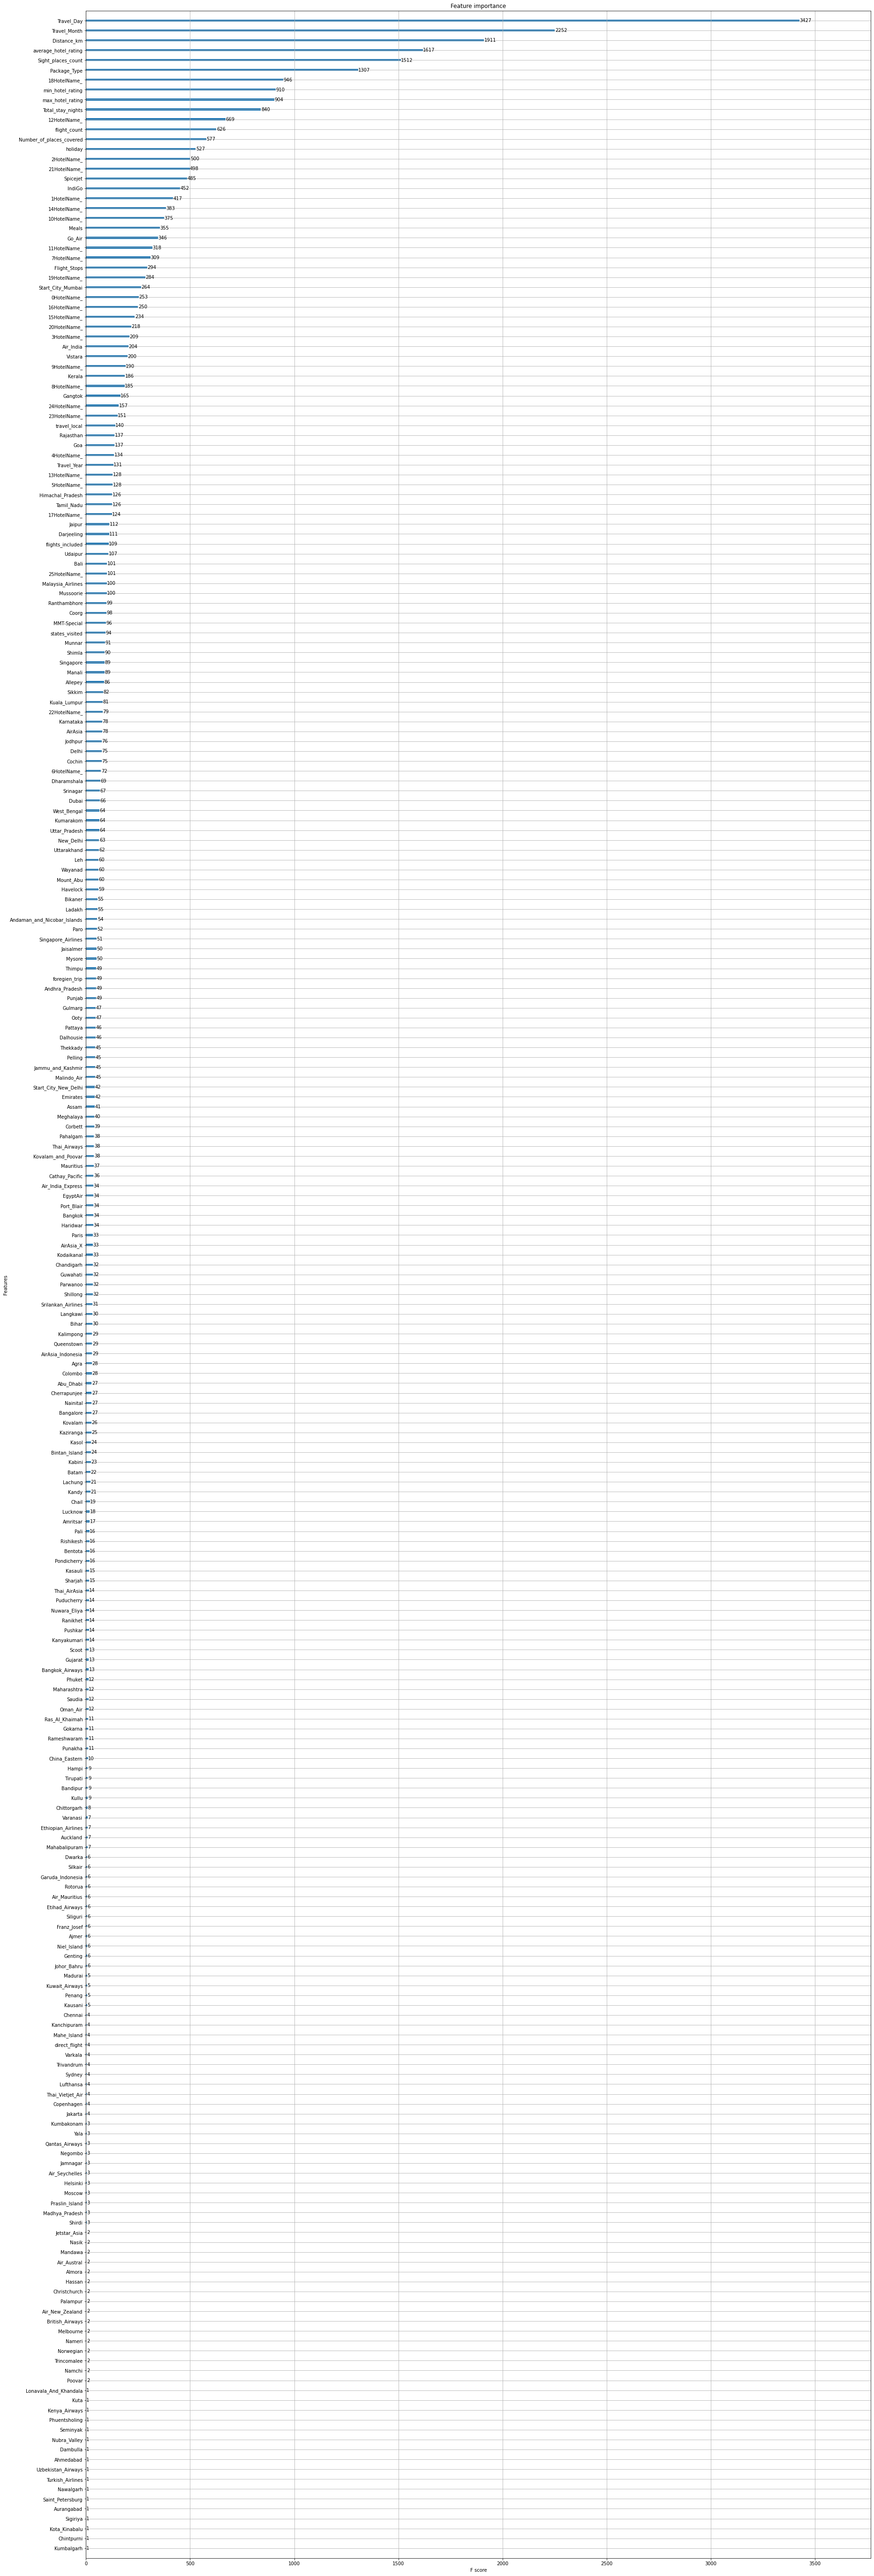

In [ ]:
from xgboost import plot_importance


def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (30,100))

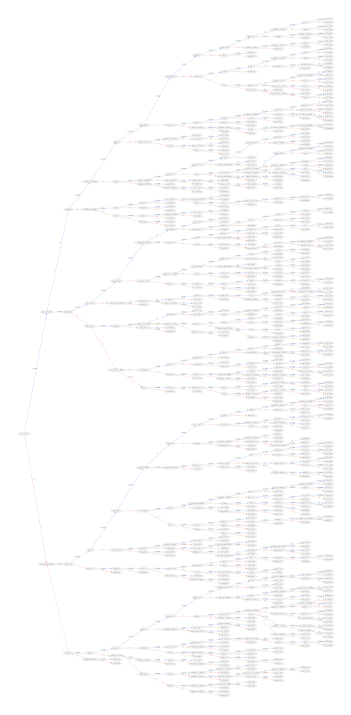

In [ ]:
fig = plt.figure(dpi=180)
ax = plt.subplot(1,1,1)
plot_tree(model, num_trees=4, ax = ax,rankdir='LR')
 
#plt.tight_layout()
plt.savefig("treeee_structure.pdf")
#plt.show()

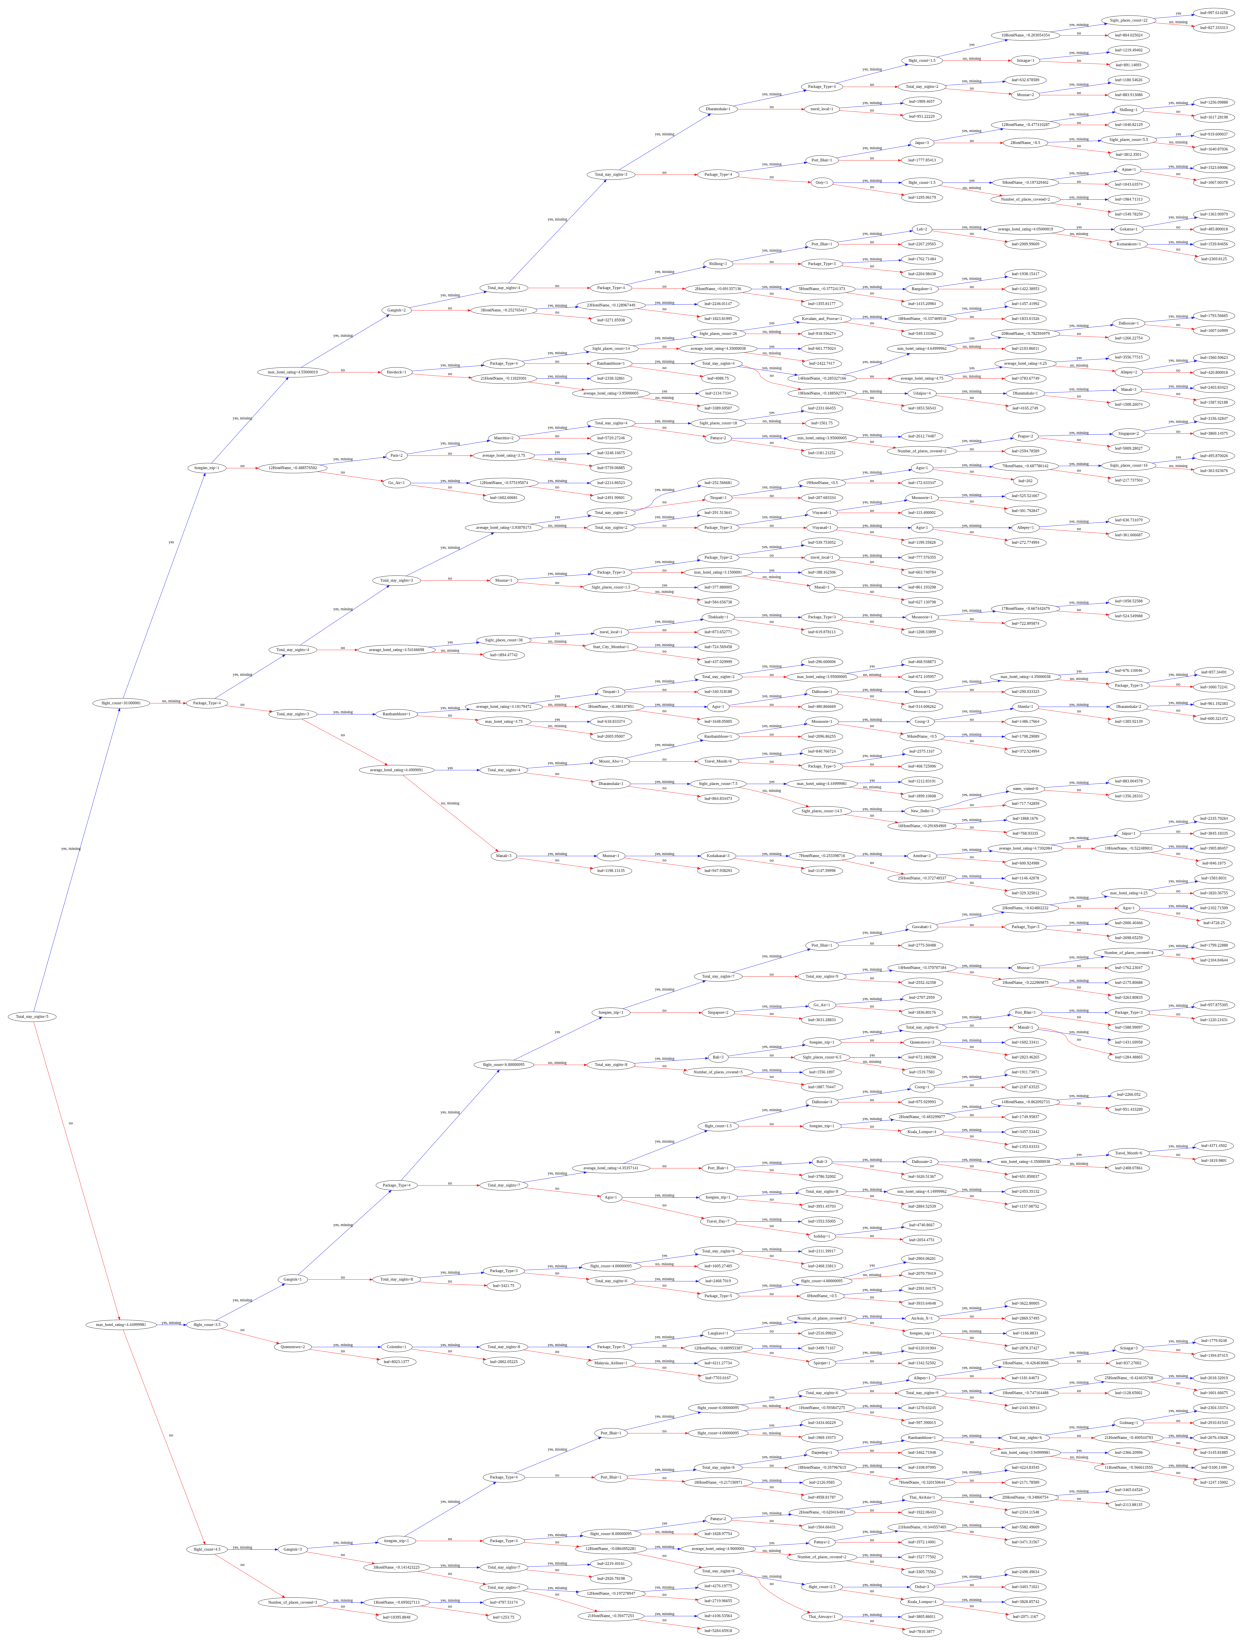

In [ ]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(model, num_trees=0, rankdir='LR',ax=ax)
plt.show()

In [ ]:
plt.savefig("imahe.pdf")

<Figure size 1080x360 with 0 Axes>

LightGBM

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
ts = time.time()

model = LGBMRegressor(
    max_depth=10,
    n_estimator=400,
    learning_rate=0.2
)

model.fit(
    X_train, 
    Y_train, 
    eval_metric='rmse',
    eval_set=[(X_train, Y_train), (X_test, Y_test)], 
    verbose=True, 
    early_stopping_rounds = 50)

time.time() - ts

[1]	training's rmse: 10100.4	training's l2: 1.02019e+08	valid_1's rmse: 10556.2	valid_1's l2: 1.11433e+08
Training until validation scores don't improve for 50 rounds.
[2]	training's rmse: 9060.35	training's l2: 8.20899e+07	valid_1's rmse: 9542.23	valid_1's l2: 9.10541e+07
[3]	training's rmse: 8224.91	training's l2: 6.76491e+07	valid_1's rmse: 8751.82	valid_1's l2: 7.65943e+07
[4]	training's rmse: 7583.12	training's l2: 5.75037e+07	valid_1's rmse: 8114.34	valid_1's l2: 6.58425e+07
[5]	training's rmse: 7022.07	training's l2: 4.93095e+07	valid_1's rmse: 7555.63	valid_1's l2: 5.70875e+07
[6]	training's rmse: 6633.48	training's l2: 4.4003e+07	valid_1's rmse: 7192.26	valid_1's l2: 5.17286e+07
[7]	training's rmse: 6325.32	training's l2: 4.00097e+07	valid_1's rmse: 6854.59	valid_1's l2: 4.69854e+07
[8]	training's rmse: 6083.75	training's l2: 3.7012e+07	valid_1's rmse: 6609.75	valid_1's l2: 4.36887e+07
[9]	training's rmse: 5864.2	training's l2: 3.43888e+07	valid_1's rmse: 6380.29	valid_1's l2:

0.8540639877319336

In [ ]:
predictions=model.predict(X_test)
print("Mean Squared error is", np.sqrt(mean_squared_log_error(Y_test, predictions)))

Mean Squared error is 0.18299625531718422


In [ ]:
# !pip3 install catboost

In [ ]:
from catboost import CatBoostRegressor

In [ ]:
ts = time.time()

model = CatBoostRegressor(
    depth=12,
    iterations=350,
    eta=0.1,
    subsample=0.9,
    loss_function='RMSE',
    colsample_bylevel=0.2,
    random_seed=42,

)

model.fit(
    X_train, 
    Y_train, 
    eval_set=[(X_train, Y_train), (X_test, Y_test)], 
    verbose=True, 
    early_stopping_rounds = 50)

time.time() - ts

0:	learn: 10836.9689976	test: 10836.9689976	test1: 11303.7464234	best: 11303.7464234 (0)	total: 167ms	remaining: 58.1s
1:	learn: 10288.8711108	test: 10288.8711108	test1: 10774.8812704	best: 10774.8812704 (1)	total: 336ms	remaining: 58.5s
2:	learn: 9741.5738072	test: 9741.5738072	test1: 10254.0280008	best: 10254.0280008 (2)	total: 532ms	remaining: 1m 1s
3:	learn: 9283.7563849	test: 9283.7563849	test1: 9810.2203219	best: 9810.2203219 (3)	total: 731ms	remaining: 1m 3s
4:	learn: 8878.7180719	test: 8878.7180719	test1: 9426.5542906	best: 9426.5542906 (4)	total: 923ms	remaining: 1m 3s
5:	learn: 8544.2773483	test: 8544.2773483	test1: 9119.3947785	best: 9119.3947785 (5)	total: 1.1s	remaining: 1m 3s
6:	learn: 8241.5035578	test: 8241.5035578	test1: 8854.2091472	best: 8854.2091472 (6)	total: 1.32s	remaining: 1m 4s
7:	learn: 7917.6652842	test: 7917.6652842	test1: 8518.9714719	best: 8518.9714719 (7)	total: 1.49s	remaining: 1m 3s
8:	learn: 7653.3693407	test: 7653.3693407	test1: 8256.0737867	best: 825

66.18801546096802

In [ ]:
predictions=model.predict(X_test)
print("Mean Squared error is", np.sqrt(mean_squared_log_error(Y_test, predictions)))

Mean Squared error is 0.17585130951969263


## Submission

In [ ]:
submission['Per Person Price']=model.predict(X_test_final.drop(['Per_Person_Price'],axis=1))


In [ ]:
submission.to_csv('final_2.csv',index=False)